In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from architecture.deep_binary_classifier import DeepBinaryClassifier
from architecture.ripper_node import make_ripper_node

In [2]:
df   = pd.read_csv("./data/100_bit_artificial/1a.csv")
X = df.drop(columns="class").to_numpy(bool)
y = df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset Shape               : {df.shape}")
print(f"Train-Test-Split            : {X_train.shape[0]} vs. {X_test.shape[0]}")
print(f"Train label distribution    : {y_train.sum()} (True) vs. {y_train.size - y_train.sum()} (False)")

Dataset Shape               : (10000, 101)
Train-Test-Split            : 8000 vs. 2000
Train label distribution    : 4605 (True) vs. 3395 (False)


In [3]:
def get_layer_outputs(model, X):
    layer_outputs = []
    X_layer = X
    for nodes in model.layers:
        X_layer = np.column_stack([node(X_layer) for node in nodes])
        layer_outputs.append(X_layer)

    return layer_outputs


def get_node_accuracies(model, X, y):
    layer_outputs = get_layer_outputs(model, X)

    node_accuracies = []
    for layer_output in layer_outputs:
        layer_accs = [accuracy_score(node_out, y) for node_out in layer_output.T]
        node_accuracies.append(layer_accs)

    return node_accuracies

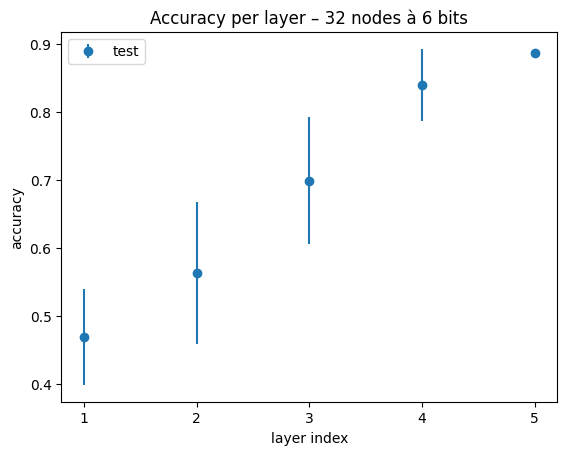

In [4]:
# Accuracy distribution across the 5 hidden layers

hidden_layer_count  = 4
layer_node_count    = 32
layer_bit_count     = 6

rip_net = DeepBinaryClassifier(
    layer_node_counts   = [layer_node_count]*hidden_layer_count + [1],
    layer_bit_counts    = [layer_bit_count]*(hidden_layer_count + 1),
    node_factory        = make_ripper_node,
    seed                = 42,
    jobs                = os.cpu_count(),
)
rip_net.fit(X_train, y_train)

node_train_accs = get_node_accuracies(rip_net, X_train, y_train)
layer_train_accs_mean = [np.mean(accs) for accs in node_train_accs]
layer_train_accs_std  = [np.std(accs) for accs in node_train_accs]

node_test_accs = get_node_accuracies(rip_net, X_test, y_test)
layer_accuracies_mean = [np.mean(accs) for accs in node_test_accs]
layer_accuracies_std  = [np.std(accs) for accs in node_test_accs]

plt.errorbar(range(1, hidden_layer_count+2), layer_accuracies_mean, yerr=layer_accuracies_std, fmt="o", label="test")
#plt.errorbar(range(1, hidden_layer_count+2), layer_train_accs_mean, yerr=layer_train_accs_std, fmt="o", label="train")
plt.xticks(range(1, hidden_layer_count+2))
plt.title(f"Accuracy per layer – {layer_node_count} nodes à {layer_bit_count} bits")
plt.xlabel("layer index")
plt.ylabel("accuracy")
plt.legend()
plt.show()

  4 nodes per layer: train 0.56  |  test 0.56
  8 nodes per layer: train 0.49  |  test 0.48
 16 nodes per layer: train 0.65  |  test 0.65
 32 nodes per layer: train 0.76  |  test 0.77
 64 nodes per layer: train 0.75  |  test 0.75


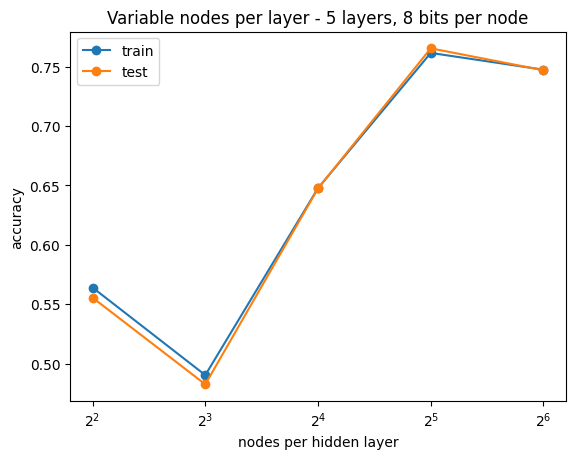

In [5]:
# Variable number of nodes per layer (fixed 8-bit iputs)

hidden_layer_count = 4
layer_node_counts  = [4, 8, 16, 32, 64]
layer_bit_count   = 4

train_acc, test_acc = [], []
for layer_node_count in layer_node_counts:
    rip_net = DeepBinaryClassifier(
        layer_node_counts   = [layer_node_count]*hidden_layer_count + [1],
        layer_bit_counts    = [layer_bit_count]*(hidden_layer_count + 1),
        node_factory        = make_ripper_node,
        seed                = 42,
        jobs                = os.cpu_count(),
    )
    rip_net.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rip_net.predict(X_train)))
    test_acc .append(accuracy_score(y_test , rip_net.predict(X_test)))

    print(f"{layer_node_count:>3} nodes per layer: train {train_acc[-1]:.2f}  |  test {test_acc[-1]:.2f}")


plt.plot(layer_node_counts, train_acc, marker="o", label="train")
plt.plot(layer_node_counts, test_acc , marker="o", label="test")
plt.title("Variable nodes per layer - 5 layers, 8 bits per node")
plt.xlabel("nodes per hidden layer")
plt.ylabel("accuracy")
plt.legend()
plt.xscale("log", base=2)
plt.show()

 2-bit nodes: train 0.48  |  test 0.48
 4-bit nodes: train 0.65  |  test 0.65
 8-bit nodes: train 0.71  |  test 0.72
16-bit nodes: train 0.74  |  test 0.74


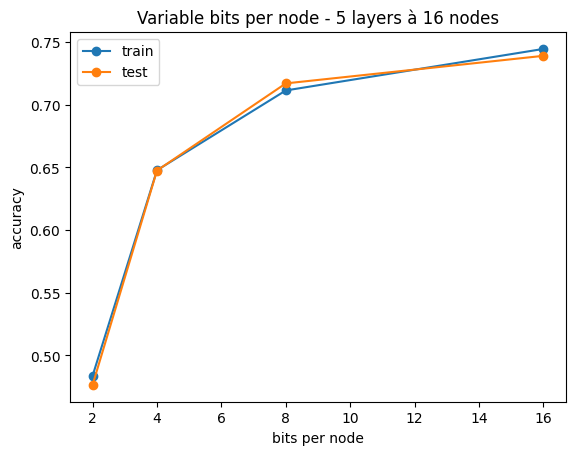

In [6]:
# Variable number of bits per node (fixed 16 nodes per layer)

hidden_layer_count  = 4
layer_node_count    = 16
layer_bit_counts    = [2, 4, 8, 16]

train_acc, test_acc = [], []
for layer_bit_count in layer_bit_counts:
    rip_net = DeepBinaryClassifier(
        layer_node_counts   = [layer_node_count]*hidden_layer_count + [1],
        layer_bit_counts    = [layer_bit_count]*(hidden_layer_count + 1),
        node_factory        = make_ripper_node,
        seed                = 42,
        jobs                = os.cpu_count(),
    )
    rip_net.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rip_net.predict(X_train)))
    test_acc .append(accuracy_score(y_test , rip_net.predict(X_test)))

    print(f"{layer_bit_count:>2}-bit nodes: train {train_acc[-1]:.2f}  |  test {test_acc[-1]:.2f}")


plt.plot(layer_bit_counts, train_acc, marker="o", label="train")
plt.plot(layer_bit_counts, test_acc , marker="o", label="test")
plt.title("Variable bits per node - 5 layers à 16 nodes")
plt.xlabel("bits per node")
plt.ylabel("accuracy")
plt.legend()
plt.show()